# Recurrent Neural Network

# Recurrent Neural Network

In this exercise we will build a simple RNN to work with sequential data. Feel free to try different number and types of layers, outputs, activations and hyperparamteres to see how the quality of prediction and training speed change. For example, try answering those questions:
- How does the window size affect the prediction? 
- What is the smallest window you can use that will still capture the seasonality of the data? 
- Which type of layers is best for this dataset: RNN, GRU or LSTM?

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

## DATA
Your data for this exercise is artifically generated 1D time series. It has been saved in a csv file named <code>sequential_data_ex1.csv</code> in the usual directory. This time we will be importing it to a numpy array using the <code>genfromtxt()</code> method as numpy arrays are the easiest to work with when dealing with this type of data.

As usual, we need to first create datasets for training and validation using fixed partitioning.

In [6]:
mydf=np.genfromtxt('../resource/asnlib/publicdata/sequential_data_ex1.csv',delimiter=',')
time=np.array(range(len(mydf)))
print(mydf.shape,time.shape)

(1621,) (1621,)


487

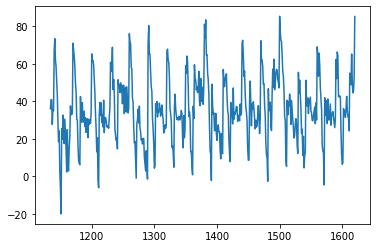

In [8]:
n=len(mydf)
#SPLIT DATA FOR TRAINIG AND TESTING
x_train = np.array(mydf[0:int(n*0.7)])
x_valid = np.array(mydf[int(n*0.7):])
time_train = time[0:int(n*0.7)]
time_valid = time[int(n*0.7):]
plt.plot(time_valid,x_valid)
len(x_valid)

### Windowing
In the next cells we will split the sequential data into examples (windows) to be fed into the network in batches. There are two ways of doing that: 

1) using the TensorFlow Dataset method (documentation here: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) - this is the one used in this notebook

2) using the <code>preprocessing.timeseries_dataset_from_array</code> method (separate notebook)

In [9]:
def windowing(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)#creates a separate dataset for each window iteration
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) #this combines all windows into batches rather than individual datasets
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))#separates each window into features and label (last value)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

#create training and test sets
window_size=50
batch_size=32
shuffle_buffer_size = 1000
train_dataset=windowing(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset=windowing(x_valid, window_size, batch_size, 1) #1 here avoids shuffling - it will make plotting of predictions easier

In [ ]:
#preview the windowed dataset here
print(len(list(train_dataset)),  'batches of windows with ', window_size,' elements created from', len(x_train), ' datapoints')
for X, y in train_dataset:
    print("Features:", X.numpy(), "Label:", y.numpy())

## MODEL & TRAINING
Build a Recurrent Neural Network to predict the data at validation timesteps. We will be using the lambda layer twice: firstly to adjust the input layer as well as loss function - your data is now 1-D and the problem is no longer classification! The second lambda layer multiplies the hypothesis function by 100 to make the prediction on the same order of magnitude as the data (notice we are not using linear activation here).

In [10]:
def build_model(lr):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0) 
])
    optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])
    return model
model =build_model(1e-5)
model.summary()
history=model.fit(train_dataset, epochs=200)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 40)          1680      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
34/34 [==============================] - 7s 59ms/step - loss: 27.3067 - mae: 27.8022
Epoch 2/200
34/34 [====

34/34 [==============================] - 1s 17ms/step - loss: 8.1979 - mae: 8.6816
Epoch 76/200
34/34 [==============================] - 1s 17ms/step - loss: 7.8663 - mae: 8.3523
Epoch 77/200
34/34 [==============================] - 1s 18ms/step - loss: 7.1615 - mae: 7.6433
Epoch 78/200
34/34 [==============================] - 1s 17ms/step - loss: 6.9140 - mae: 7.3963
Epoch 79/200
34/34 [==============================] - 1s 17ms/step - loss: 6.6494 - mae: 7.1318
Epoch 80/200
34/34 [==============================] - 1s 17ms/step - loss: 6.9434 - mae: 7.4305
Epoch 81/200
34/34 [==============================] - 1s 17ms/step - loss: 8.5465 - mae: 9.0348
Epoch 82/200
34/34 [==============================] - 1s 17ms/step - loss: 6.7939 - mae: 7.2752
Epoch 83/200
34/34 [==============================] - 1s 17ms/step - loss: 6.8727 - mae: 7.3540
Epoch 84/200
34/34 [==============================] - 1s 17ms/step - loss: 6.7887 - mae: 7.2689
Epoch 85/200
34/34 [==============================] -

34/34 [==============================] - 1s 17ms/step - loss: 6.6187 - mae: 7.1011
Epoch 160/200
34/34 [==============================] - 1s 17ms/step - loss: 6.2965 - mae: 6.7741
Epoch 161/200
34/34 [==============================] - 1s 18ms/step - loss: 6.6751 - mae: 7.1535
Epoch 162/200
34/34 [==============================] - 1s 17ms/step - loss: 6.1625 - mae: 6.6383
Epoch 163/200
34/34 [==============================] - 1s 17ms/step - loss: 6.3933 - mae: 6.8719
Epoch 164/200
34/34 [==============================] - 1s 17ms/step - loss: 6.4588 - mae: 6.9382
Epoch 165/200
34/34 [==============================] - 1s 17ms/step - loss: 6.0449 - mae: 6.5267
Epoch 166/200
34/34 [==============================] - 1s 17ms/step - loss: 6.7039 - mae: 7.1857
Epoch 167/200
34/34 [==============================] - 1s 17ms/step - loss: 6.6507 - mae: 7.1278
Epoch 168/200
34/34 [==============================] - 1s 17ms/step - loss: 5.9196 - mae: 6.4036
Epoch 169/200
34/34 [=======================

## EVALUATE
Use your optimised model to predict and plot the validation data. 

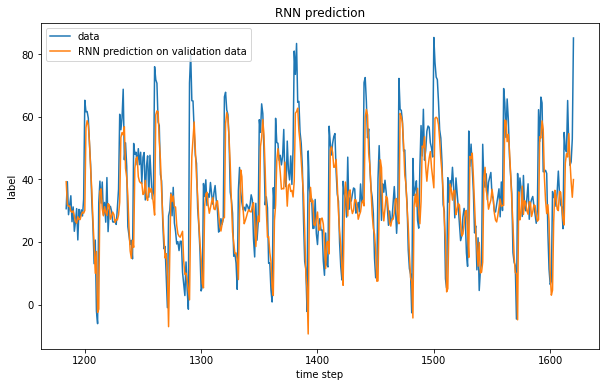

In [13]:
forecast=model.predict(valid_dataset) #this has 50 fewer datapoints than the cell below
#plot your results alongside ground truth
plt.figure(figsize=(10, 6))
plt.plot(time_valid[50:],x_valid[50:], label='data')
plt.plot(time_valid[50:],forecast, label='RNN prediction on validation data')
plt.xlabel('time step')
plt.ylabel('label')
plt.title('RNN prediction')
plt.legend()

Alternatively, use <code>model.predict</code> window by window on the full dataset and only plot the validation part (after the split). It's important to remember to stop the loop before reaching the beginning of the last window, otherwise, the code will run out of data.

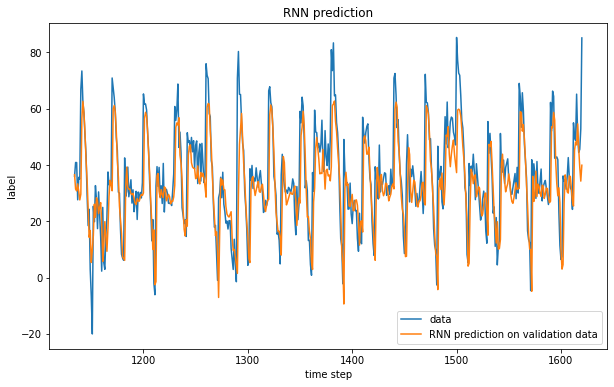

In [14]:
prediction=[]
for time in range(len(mydf) - window_size):
    prediction.append(model.predict(mydf[time:time + window_size][np.newaxis]))

prediction = prediction[int(n*0.7)-window_size:]
results = np.array(prediction)[:, 0, 0]
#plot your results alongside ground truth
plt.figure(figsize=(10, 6))
plt.plot(time_valid,x_valid, label='data')
plt.plot(time_valid,results, label='RNN prediction on validation data')
plt.xlabel('time step')
plt.ylabel('label')
plt.title('RNN prediction')
plt.legend()